## Latent Dirichlet Allocation (LDA)

In this notebook we will take a closer look at the functionality and usage of LDA by using the python package [gensim](https://pypi.org/project/gensim/). We will use a collection of the prestigious [NIPS](https://nips.cc/) conference obtained from a [kaggle competition](https://www.kaggle.com/benhamner/nips-papers). You can download the data from the kaggle link, it will also be attached to this file and is placed in the folder "Data". 

First we will have to pre-process the data. For now, I will only illustrate removing upper-casing, punctuation and stop words. As we will see down the line, more pre-processing should be done and for your assignment we expect you to carefully analyse the results of pre-processing the data and report any additional steps you have taken to overcome said problems.

Please note that I highly reccomend to use [Anaconda Navigator](https://www.anaconda.com/products/individual) to manage your python environment as this enables you to easily manage your python environment and allows you to use 'pip install <package>' to install dependancies.

In [ ]:
import pandas as pd
import numpy as np
import string # Used to remove stopwords
import nltk # Used to 
import spacy # download the "en_core_web_sm" python -m spacy download en_core_web_sm
import gensim.corpora as corpora
import matplotlib.pyplot as plt

from pprint import pprint
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from tqdm import tqdm

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dabed001\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Load the data
First we will read the data using the pandas function read_csv() and sample 10% of the available data. Running the notebook for the entirety of the data will take over 30 minutes on a decent computer.

In [ ]:
df = pd.read_csv('papers.csv', error_bad_lines=False, engine='c').sample(frac = 0.1)

C:\Users\Dabed001\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


# Pre-process the data
Next we will do some basic pre-processing such as converting the upper cases to lower cases, removal of punctuation and the removal of stopwords. The package "stopwords" takes care of what is considered to be a stop word or not. Of course you can create your own list of stopwords if you deem that more suitable for your project

In [ ]:
def column_to_lower(df, column):
    """
        Input: df and a corresponding column
        Output: converted dataframe column 
        Function: Converts all strings in a column of a dataframe to lowercases.
    """
    return df[column].str.lower()

df['title'] = column_to_lower(df, 'title')
df['abstract'] = column_to_lower(df, 'abstract')
df['paper_text'] = column_to_lower(df, 'paper_text')

In [ ]:
def column_remove_punctuation(df, column):
    """
        Input: df and a corresponding column
        Output: converted dataframe column 
        Function: Removes all punctuation in a column of a dataframe.
    """
    return df[column].str.replace('[{}]'.format(string.punctuation), '')
    
df['title'] = column_remove_punctuation(df, 'title')
df['abstract'] = column_remove_punctuation(df, 'abstract')
df['paper_text'] = column_remove_punctuation(df, 'paper_text')

C:\Users\Dabed001\AppData\Local\Temp/ipykernel_22268/4124342936.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  return df[column].str.replace('[{}]'.format(string.punctuation), '')


In [ ]:
def column_remove_stop_words(df, column, stopwords):
    """
        Input: df and a corresponding column
        Output: converted dataframe column 
        Function: Removes all stopwords for a given column in a dataframe.
        NOTE: This might take a few minutes!
    """
    print(f"Currently processing the column: {column}")
    df[column] = df[column].replace(to_replace='None', value=np.nan).dropna()
    return df[column].apply(lambda x: ' '.join([word for word in str(x).split() if word not in (stopwords)]))

stop_words = stopwords.words('english')
print("NOTE: This function might take a few minutes to process!")
df['title'] = column_remove_stop_words(df, 'title', stop_words)
df['abstract'] = column_remove_stop_words(df, 'abstract', stop_words)
df['paper_text'] = column_remove_stop_words(df, 'paper_text', stop_words) # it might take a few minutes to remove all the stop words from the paper text
print("Done!")

NOTE: This function might take a few minutes to process!
Currently processing the column: title
Currently processing the column: abstract
Currently processing the column: paper_text
Done!


# Feeding data to the model
Great! We have now taken some basic pre-processing steps to deal with the data. Dependant on your project and dataset you might want to consider other pre-processing functions as well. In fact, will the taken steps ensure a robust and interpretable result? 

First we will convert the available cleaned data to a format such that the package Gensim knows how to use the data. Dependant on the package that you will use this format might differentiate. 

In [ ]:
def obtain_lda_model(texts_list, alpha = 'auto'):
    """
        Input: texts_list of format [[sent_1], ..., [sent_n]] where for each sent_i = [word_1, ..., word_n]
        Output: LDA model (gensim model)
        Function: Create a dictonary object that is used to create an LDA model.
    """
    dictionary = Dictionary(texts_list) # Construct word <-> id mappings used by the LDA model
    # Filter words that occur in less than 15 the documents (no_above)
    # Filter words that occur in less than 50% of the provided documents
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)  
    common_corpus = [dictionary.doc2bow(text) for text in texts_list]
    _ = dictionary[0] # need this line to force-load the data in the kernel
    id2word = dictionary.id2token
    
    # For further reading on the documentation of the LdaModel please see: https://radimrehurek.com/gensim/models/ldamodel.html
    lda = LdaModel(common_corpus, id2word=id2word,num_topics=20, decay = 0.6, minimum_probability=0.001, alpha = alpha)
    return [lda,common_corpus,dictionary]

Investigating the result of the cell below we notice that there are topics where specific non-sensical words ("xi", "\x7f" "\\" etc.) are dominating the topical distribution. This results in noisy topic estimations as these keywords (numbers, loose characters, non-sensical words) are not relevant for our analysis. We should do some more pre-processing. 

In [ ]:
texts_list = [[word for word in document.split()] for document in df['paper_text'].tolist()]
lda = obtain_lda_model(texts_list)[0]
pprint(lda.print_topics())

[(0,
  '0.003*"image" + 0.003*"feature" + 0.003*"xi" + 0.002*"images" + '
  '0.002*"gradient" + 0.002*"state" + 0.002*"theorem" + 0.002*"classification" '
  '+ 0.002*"layer" + 0.002*"sparse"'),
 (1,
  '0.005*"state" + 0.004*"policy" + 0.004*"reward" + 0.004*"image" + '
  '0.003*"features" + 0.003*"images" + 0.003*"xi" + 0.003*"feature" + '
  '0.002*"noise" + 0.002*"action"'),
 (2,
  '0.003*"image" + 0.003*"prior" + 0.002*"tree" + 0.002*"points" + '
  '0.002*"noise" + 0.002*"features" + 0.002*"images" + 0.002*"bound" + '
  '0.002*"rate" + 0.002*"search"'),
 (3,
  '0.003*"graph" + 0.003*"samples" + 0.003*"state" + 0.003*"xi" + '
  '0.003*"points" + 0.003*"bound" + 0.002*"log" + 0.002*"constraints" + '
  '0.002*"theorem" + 0.002*"features"'),
 (4,
  '0.004*"image" + 0.004*"feature" + 0.003*"features" + 0.003*"images" + '
  '0.002*"sparse" + 0.002*"clustering" + 0.002*"policy" + 0.002*"state" + '
  '0.002*"points" + 0.002*"local"'),
 (5,
  '0.004*"features" + 0.004*"points" + 0.003*"log" +

One possible solution would be to only consider words that contain a specific Part-of-Speech tag (e.g. Nouns, Verbs, Adjectives etc.). 

In [ ]:
def pos_filter(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'NNP']):
    """
        Input: texts_list of format [[sent_1], ..., [sent_n]] where for each sent_i = [word_1, ..., word_n]
        Output: texts_list of format [[sent_1], ..., [sent_n]] where for each sent_i = [word_1, ..., word_n]
        Function: Uses object NLP from package "spacy" to further pre-process the data using PoS-tags.
    """
    nlp = spacy.load('en_core_web_sm') # for more info see https://spacy.io/models/en
    texts_out = []
    counter = 0
    for sent in tqdm(texts):
        if len(sent) <= 1:
            pass
        doc = nlp(" ".join(sent)) # convert each sentence to an NLP object such that we can extract the POS.
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
        counter += 1
        #if counter == 500: # uncomment this and set the counter to a specific value to reduce computational time
            #break
    return texts_out

extra_filtered_texts_list = pos_filter(texts_list)

100%|██████████| 724/724 [04:40<00:00,  2.59it/s]


Now we can re-run the experiment, that is we estimate a new LDA model, and store the results in a dataframe. The actual LDA values are omitted from the dataframe but can easily be added. It is straight forward to save the dataframe in a CSV file. 

In [ ]:
to_remove = [''] # if you investigate the topics and find that specific words that are not valuable should not be in the topic
# you can edit those words in this list and run this cell to obtain a new lda model and investigate.
new_texts_lists = [[word for word in document.split() if word not in to_remove and len(word)>1] for document in extra_filtered_texts_list]

[new_lda, corpus, id2word] = obtain_lda_model(new_texts_lists)
topic_keywords,topic_keyvalues = [],[]
n_topics = 15 # set the number of topics that we are interested in
n_keywords = 15 # set the number of keywords that each topic should contain
for (topic, values) in new_lda.print_topics(n_topics, n_keywords):
    temp_list_keywords,  temp_list_keyvalues = [],[]
    for value in (str(values).split()):
        if "*" in value:
            value = value.split("\"")
            value_keyword = float(value[0][:-1])
            keyword = value[1]
            temp_list_keywords.append(keyword)
            temp_list_keyvalues.append(value_keyword)
    topic_keywords.append(temp_list_keywords)
    topic_keyvalues.append(temp_list_keyvalues)
    

# save the output of the model in a dataframe. You can also store the list of "topic_keyvalues" to save the estimated values.
df_to_save = pd.DataFrame(topic_keywords, index = [f"Topic {topic_number+1}" for topic_number in range(n_topics)],
                  columns = [f"Keyword #{index+1}" for index, _ in enumerate(topic_keywords[0])])

In [ ]:
display(df_to_save)
df_to_save.to_csv("results_LDA_model.csv")

,Keyword #1,Keyword #2,Keyword #3,Keyword #4,Keyword #5,Keyword #6,Keyword #7,Keyword #8,Keyword #9,Keyword #10,Keyword #11,Keyword #12,Keyword #13,Keyword #14,Keyword #15
Topic 1,node,cluster,reward,noise,policy,graph,dataset,action,tree,expert,bound,prior,complexity,train,observation
Topic 2,image,code,kernel,cluster,instance,gaussian,train,objective,dataset,topic,bound,label,reward,object,bind
Topic 3,topic,word,cluster,image,group,theorem,sparse,update,layer,tensor,neuron,gaussian,latent,train,dataset
Topic 4,image,gaussian,bound,tree,dynamic,regression,theorem,field,online,equation,complexity,bind,train,noise,kernel
Topic 5,cluster,metric,image,object,regression,dataset,bind,bound,distance,train,log,complexity,update,label,sequence
Topic 6,image,word,graph,topic,label,prior,estimation,bind,log,loss,iteration,sequence,language,sparse,update
Topic 7,cluster,graph,bind,label,category,unit,classification,theorem,object,target,bound,dataset,local,inference,dimension
Topic 8,image,graph,unit,theorem,kernel,map,layer,sequence,train,dataset,sparse,loss,bound,prediction,architecture
Topic 9,image,object,dataset,classification,train,neuron,estimator,sequence,game,convergence,equation,theorem,noise,gradient,dynamic
Topic 10,image,label,kernel,policy,cluster,instance,theorem,prior,local,object,map,bind,classification,update,classifier


# Visualization
We will use the package pyLDAvis to generate a visualization of topics. Here the size of the buble of a topic the higher the proportion of times it has been assigned. The light blue bars indicate the frequency of words in the corpus while red bars give the estimated times a word was generated by a particular topic. Furthermore, if bubles are close together then the topics are similar to eachother in terms of the words that define them.

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
# Run visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(new_lda, corpus, dictionary=id2word, mds='mmds')
vis

C:\Users\Dabed001\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.008483  0.023380       1        1  6.767538
3      0.002030 -0.024070       2        1  6.758142
15     0.002793  0.021039       3        1  6.640262
18    -0.019698 -0.005691       4        1  6.298699
1     -0.011193  0.004169       5        1  5.911044
17    -0.001151  0.011840       6        1  5.732556
0      0.020150 -0.001928       7        1  5.686704
7     -0.025205  0.001450       8        1  5.645126
12     0.006304  0.010706       9        1  5.576594
6     -0.003792  0.001083      10        1  5.564682
14    -0.014186 -0.009746      11        1  5.015377
2      0.004886 -0.007925      12        1  4.623414
8     -0.011379  0.011756      13        1  4.426577
16     0.009157 -0.002855      14        1  4.291133
13     0.017009 -0.008856      15        1  4.288521
5      0.018903  0.008483      16        1  4.093021
9      0.011529  0.012426      17        1  4.020089
10     0.013717 -0.019727      18        1  4.017730
11    -0.008678 -0.015417      19        1  3.456265
4     -0.002713 -0.010116      20        1  1.186525, topic_info=                Term         Freq        Total Category  logprob  loglift
220            image  5081.000000  5081.000000  Default  30.0000  30.0000
593          cluster  2729.000000  2729.000000  Default  29.0000  29.0000
980            topic  1163.000000  1163.000000  Default  28.0000  28.0000
773            layer  2449.000000  2449.000000  Default  27.0000  27.0000
1354            word  1828.000000  1828.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
1066           graph    23.581094  2505.258830  Topic20  -5.8984  -0.2316
471          theorem    22.789354  2531.387549  Topic20  -5.9326  -0.2761
70    classification    21.761863  2093.032761  Topic20  -5.9787  -0.1321
498           update    20.661668  1954.805468  Topic20  -6.0306  -0.1156
301            noise    20.045490  1928.907796  Topic20  -6.0609  -0.1326

[1428 rows x 6 columns], token_table=      Topic      Freq Term
term                      
2250      1  0.035689   2i
2250      2  0.071377   2i
2250      3  0.035689   2i
2250      4  0.035689   2i
2250      5  0.035689   2i
...     ...       ...  ...
1794     15  0.059713   zj
1794     16  0.119426   zj
1794     17  0.029857   zj
1794     18  0.029857   zj
1794     19  0.059713   zj

[14170 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 4, 16, 19, 2, 18, 1, 8, 13, 7, 15, 3, 9, 17, 14, 6, 10, 11, 12, 5])

### Visualization of a document
Next we will visualize the distribution of active of topics in a document

<BarContainer object of 9 artists>

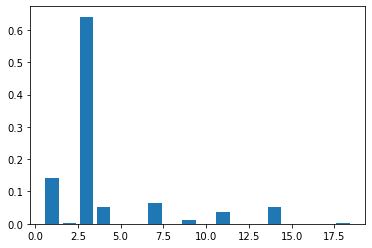

In [ ]:
topics = new_lda[corpus[2]] # 0 denotes the document
plt.bar(list(zip(*topics))[0], list(zip(*topics))[1])

### Visualization of top topics
Now we will visualize the probability distribution over documents of the highest probability topic.

In [ ]:
topic_dist = pd.DataFrame(columns = ['topics', 'topic_list', 'top_topic','top_topic_prob'])
topic_dist.topics = new_lda[corpus]
topic_dist.topic_list = topic_dist.topics.apply(lambda y: [x[0] for x in y])
topic_dist.top_topic = topic_dist.topics.apply(lambda y: max(y, key = lambda x: x[1])[0])
topic_dist.top_topic_prob = topic_dist.topics.apply(lambda y: max(y, key = lambda x: x[1])[1])
print(topic_dist.head())

                                              topics  \
0  [(1, 0.0016296994), (3, 0.14645778), (4, 0.109...   
1  [(0, 0.0024550196), (2, 0.13103983), (3, 0.484...   
2  [(1, 0.15438229), (3, 0.6394857), (4, 0.036825...   
3  [(0, 0.1201494), (2, 0.67971736), (8, 0.022785...   
4                 [(2, 0.9239949), (16, 0.07379339)]   

                                   topic_list  top_topic  top_topic_prob  
0                 [1, 3, 4, 5, 9, 15, 17, 18]          5        0.564315  
1  [0, 2, 3, 4, 8, 9, 10, 15, 16, 17, 18, 19]          3        0.484131  
2                     [1, 3, 4, 7, 9, 11, 14]          3        0.639486  
3                       [0, 2, 8, 13, 17, 19]          2        0.679717  
4                                     [2, 16]          2        0.923995  


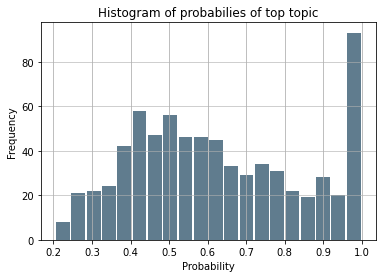

In [ ]:
topic_dist.top_topic_prob.plot.hist(grid = True, bins = 20, rwidth = 0.9, color = '#607c8e')
plt.title('Histogram of probabilies of top topic')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

We can also do the same for the highest probability topics

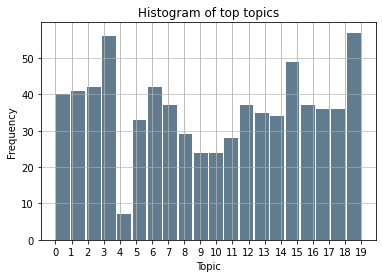

In [ ]:
topic_dist.top_topic.plot.hist(grid = True, bins = 20, rwidth = 0.9, color = '#607c8e')
plt.title('Histogram of top topics')
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.xticks(range(20))
plt.grid(axis='y', alpha=0.75)

# Alpha Parameter
What if we choose a different alpha parameter for the LDA model? A lower alpha parameter will result in a sparser assignation of topics. [Here](http://i.amcat.nl/lda/understanding_alpha.html) you can find an explanation on how this parameter works with examples. If we visualize the LDA model with alpha = 0.1 (instead of the default 1) we can observe that topic bubles are further apart than before.

In [ ]:
[new_lda_alpha, corpus_alpha, id2word_alpha] = obtain_lda_model(new_texts_lists, 0.1)
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(new_lda_alpha, corpus_alpha, dictionary=id2word_alpha, mds='mmds')
vis

C:\Users\Dabed001\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.013214 -0.013075       1        1  8.529900
10     0.003274 -0.013679       2        1  7.459183
6     -0.023631  0.006616       3        1  6.660284
12    -0.009038  0.023411       4        1  6.238289
11     0.015269 -0.018227       5        1  6.128890
8      0.026468  0.005750       6        1  5.998170
1      0.002313  0.010526       7        1  5.560760
17    -0.013797 -0.013642       8        1  5.394537
2     -0.021103  0.010791       9        1  4.945684
3      0.017042  0.007166      10        1  4.692108
4      0.007641  0.011841      11        1  4.625704
15     0.005863  0.022757      12        1  4.561838
7     -0.015987 -0.009276      13        1  4.468974
9     -0.005479  0.013658      14        1  4.319785
5     -0.000051 -0.025363      15        1  4.233765
14    -0.010720  0.002952      16        1  4.190752
18    -0.001951 -0.017337      17        1  4.085619
19    -0.003456 -0.005399      18        1  2.979640
13     0.001024  0.003447      19        1  2.864572
0      0.013106 -0.002918      20        1  2.061547, topic_info=             Term         Freq        Total Category  logprob  loglift
220         image  4929.000000  4929.000000  Default  30.0000  30.0000
1848       policy  2022.000000  2022.000000  Default  29.0000  29.0000
1066        graph  2434.000000  2434.000000  Default  28.0000  28.0000
593       cluster  2761.000000  2761.000000  Default  27.0000  27.0000
269          loss  2204.000000  2204.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
471       theorem    41.509798  2442.885741  Topic20  -5.8854  -0.1933
315   observation    35.907087  1536.491069  Topic20  -6.0304   0.1254
1647   prediction    36.299319  1640.545559  Topic20  -6.0195   0.0707
983         train    37.128045  2325.020445  Topic20  -5.9969  -0.2554
301         noise    36.025755  1899.681736  Topic20  -6.0271  -0.0835

[1415 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.041010      2
0         2  0.041010      2
0         3  0.092272      2
0         4  0.030757      2
0         5  0.030757      2
...     ...       ...     ...
3288     16  0.030616  yellow
3288     17  0.061232  yellow
3288     18  0.030616  yellow
3288     19  0.045924  yellow
3288     20  0.045924  yellow

[14169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 11, 7, 13, 12, 9, 2, 18, 3, 4, 5, 16, 8, 10, 6, 15, 19, 20, 14, 1])

We can also plot the posterior estimated assymetric alpha parameter as the proportion of times a topic appears in the corpus.

It turns out that here the sizes of the topics are very comparable, but that a value just below 0.1 is best fitting the data.


<BarContainer object of 20 artists>

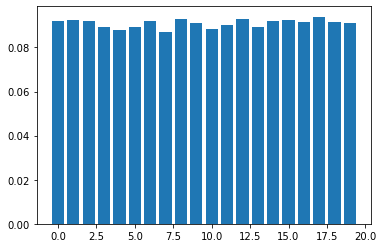

In [ ]:
plt.bar(list(range(20)), new_lda.alpha)

# Conclusion
In this short tutorial the basic usage of LDA is shown on a collection of papers from the prestigious NIPS conference. There are many more methods to further pre-process the data and the LDA model has many more parameters that are worth investigating. It is up to the reader to further tweak the LDA model and its paramaters and draw conclusions of the output of the LDA model, i.e what do the different topics represent? 